For evaluation of ML models weighted absolute percentage error (WAPE) is used as quality metric.

$$\text{WAPE}(y, \hat{y}\ ) = \frac{100\%}{N} \frac{\sum_{}^{}y_i - \hat{y}_i}{\sum_{}^{}y_i}$$

## Import

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ignore warnings when graphs are plotted
import warnings

warnings.filterwarnings("ignore")


# define func for WAPE calculation
def wape_f(y_true, y_pred):
    return round(np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100, 3)


def zscore(window):

    def zscore_(x):
        r = x.rolling(window=window)
        m = r.mean().shift(1)
        s = r.std(ddof=0).shift(1)
        z = ((x - m) / s).round(2)
        return z

    zscore_.__name__ = "zscore_"
    return zscore_

## Read data

In [3]:
train_df = pd.read_parquet("../data/train_df.parquet")
eval_df = pd.read_parquet("../data/eval_df.parquet")
test_df = pd.read_parquet("../data/test_df.parquet")

In [4]:
# check data sample
train_df.head(1)

,date,city_name,store_id,category_id,product_id,price,weather_desc,humidity,temperature,pressure,...,month,is_month_start,is_month_end,year,quarter,season,sales_lag_1_week,sales_lag_2_week,sales_lag_3_week,median_lag
21,2021-09-09,Moscow,1,1,1,4.79,partly cloudy,78.9375,15.0625,747.0,...,9,False,False,2021,3,autumn,12.0,23.0,20.0,20.0


### Data transformation
univariate time-series of number of clients

In [11]:
# group daily sales in each city

train_df_clients = (
    train_df.loc[:, ["date", "sales"]].groupby(["date"], as_index=False).sum()
)
eval_df_clients = (
    eval_df.loc[:, ["date", "sales"]].groupby(["date"], as_index=False).sum()
)
test_df_clients = (
    test_df.loc[:, ["date", "sales"]].groupby(["date"], as_index=False).sum()
)

train_df_clients.head()

,date,sales
0,2021-09-09,22492
1,2021-09-10,36936
2,2021-09-11,41411
3,2021-09-12,41285
4,2021-09-13,19973


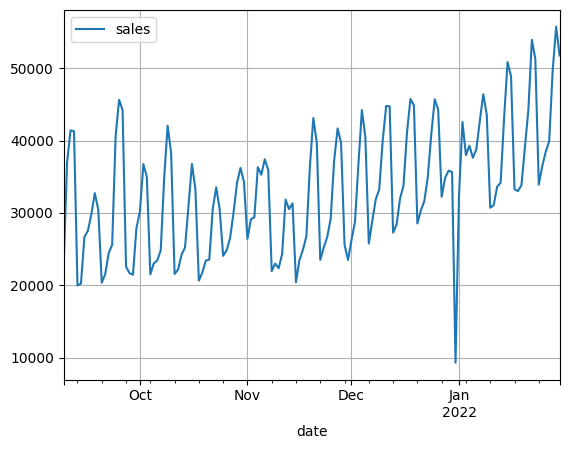

In [12]:
train_df_clients[["sales", "date"]].set_index("date").plot()
plt.grid()

In [16]:
# in train_df_clients only

train_df_clients = train_df_clients.assign(
    zscore=train_df_clients.sales.transform(zscore(21))
)

train_df_clients = train_df_clients[
    # high sales can be associated with promo and marketing features
    # (train_df_clients.zscore<=3)|
    # low sales can be more of anomaly
    (train_df_clients.zscore >= -2)
]

train_df_clients.drop(columns="zscore", inplace=True)

# train_df_clients[
#     train_df_clients.zscore<-2
# ]

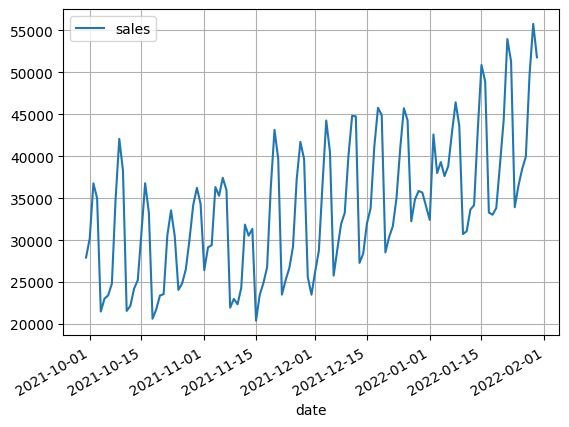

In [17]:
train_df_clients[["sales", "date"]].set_index("date").plot()
plt.grid()

## ML models

### SARIMA

In [ ]:
# Seasonal - fit stepwise auto-ARIMA


SARIMA_model = pm.auto_arima(
    train_df_clients.sales,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=7,  # 12 is the frequncy of the cycle
    start_P=0,
    seasonal=True,  # set to seasonal
    d=None,
    D=1,  # order of the seasonal differencing
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

In [ ]:
predicted = SARIMA_model.predict(
    n_periods=14,
    # return_conf_int=True,
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
y_true = np.concatenate(
    [eval_df_clients.sales.values, test_df_clients.sales.values], axis=0
)


wape_f(y_true, predicted.values)

4.473

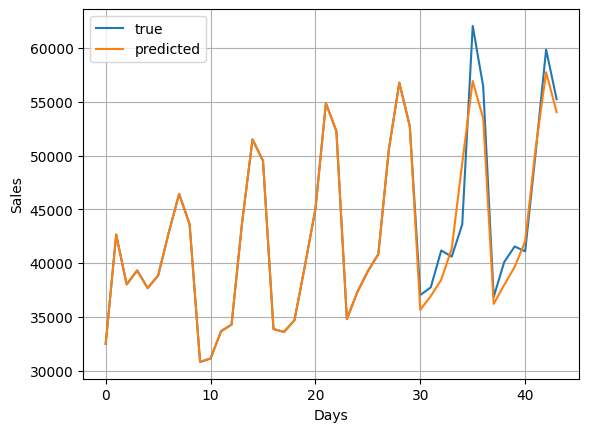

In [ ]:
plt.plot(np.concatenate([train_df_clients.sales[-30:], y_true]), label="true")
plt.plot(
    np.concatenate([train_df_clients.sales[-30:], predicted.values]), label="predicted"
)
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("Days")
plt.ylabel("Sales")
plt.show()

### LSTM

<div align="justify">For predictions of df_test data Decision Tree model is used. To visualise predicted values, a graph was created that shows the mean daily sales in each city. This graph looks similar to what was observed earlier in exploratory data analysis: the same difference of rates of sales between cities; and the same tendency throughout the week.
Below, there is the head of the dataframe with number of predicted sales.</div>

In [ ]:
test_df_clients = pd.concat([eval_df_clients, test_df_clients]).reset_index(drop=True)

In [ ]:
eval_df_clients = train_df_clients[-14:].reset_index(drop=True)

train_df_clients = train_df_clients[:-14]

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train_df_clients.sales.values.reshape(-1, 1))

In [ ]:
train_df_clients.sales = scaler.transform(
    train_df_clients.sales.values.reshape(-1, 1)
).reshape(-1)
eval_df_clients.sales = scaler.transform(
    eval_df_clients.sales.values.reshape(-1, 1)
).reshape(-1)
test_df_clients.sales = scaler.transform(
    test_df_clients.sales.values.reshape(-1, 1)
).reshape(-1)

In [ ]:
train_df_clients.sales = train_df_clients.sales.astype("float32")
eval_df_clients.sales = eval_df_clients.sales.astype("float32")
test_df_clients.sales = test_df_clients.sales.astype("float32")

In [ ]:
def create_dataset(dataset, lookback, lookforward):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(dataset.shape[0] - lookback - 7 + 1):
        feature = dataset.sales[i : i + lookback]
        target = dataset.sales[i + lookback : i + lookforward + lookback]
        X.append(feature)
        y.append(target)

    X = torch.tensor(np.array(X))
    y = torch.tensor(np.array(y))
    return X, y

In [ ]:
X_train, y_train = create_dataset(train_df_clients, lookback=7, lookforward=7)
X_eval, y_eval = create_dataset(eval_df_clients, lookback=7, lookforward=7)
X_test, y_test = create_dataset(test_df_clients, lookback=7, lookforward=7)

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, hidden_state):
        super().__init__()
        torch.manual_seed(0)
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=hidden_state, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(hidden_state, 7)

    def forward(self, x):
        x, (a, b) = self.lstm(x)
        x = self.linear(a)
        return x


model = LSTM_Model(hidden_state=64)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = lambda x, y: (x - y).abs().sum() / y.sum()  # nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8
)

In [ ]:
n_epochs = 2200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.unsqueeze(-1))
        train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_eval.unsqueeze(-1))
        eval_rmse = loss_fn(y_pred, y_eval)
    print("Epoch %d: train RMSE %.4f, eval RMSE %.4f" % (epoch, train_rmse, eval_rmse))

Epoch 0: train RMSE 1.0367, eval RMSE 1.0112
Epoch 100: train RMSE 0.4289, eval RMSE 0.5212
Epoch 200: train RMSE 0.3099, eval RMSE 0.2982
Epoch 300: train RMSE 0.2792, eval RMSE 0.2319
Epoch 400: train RMSE 0.2752, eval RMSE 0.2054
Epoch 500: train RMSE 0.2704, eval RMSE 0.1902
Epoch 600: train RMSE 0.2665, eval RMSE 0.1822
Epoch 700: train RMSE 0.2620, eval RMSE 0.1664
Epoch 800: train RMSE 0.2578, eval RMSE 0.1605
Epoch 900: train RMSE 0.2527, eval RMSE 0.1607
Epoch 1000: train RMSE 0.2486, eval RMSE 0.1585
Epoch 1100: train RMSE 0.2462, eval RMSE 0.1442
Epoch 1200: train RMSE 0.2434, eval RMSE 0.1490
Epoch 1300: train RMSE 0.2418, eval RMSE 0.1464
Epoch 1400: train RMSE 0.2409, eval RMSE 0.1343
Epoch 1500: train RMSE 0.2392, eval RMSE 0.1252
Epoch 1600: train RMSE 0.2382, eval RMSE 0.1193
Epoch 1700: train RMSE 0.2371, eval RMSE 0.1254
Epoch 1800: train RMSE 0.2355, eval RMSE 0.1237
Epoch 1900: train RMSE 0.2348, eval RMSE 0.1264
Epoch 2000: train RMSE 0.2344, eval RMSE 0.1182
Epoc

In [ ]:
model.eval()
predicted = model(X_test).detach().numpy()

In [ ]:
wape_f(y_test.detach().numpy(), predicted)

8.37

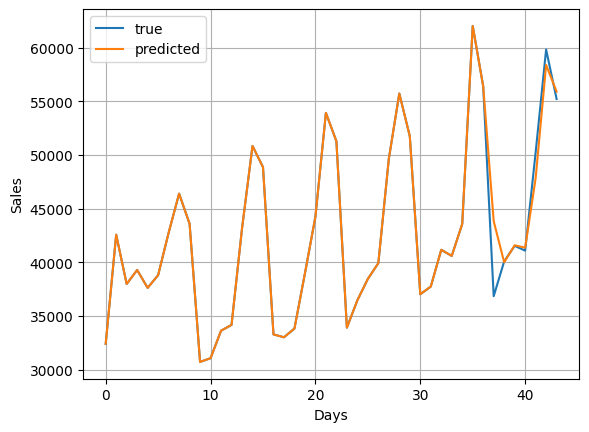

In [ ]:
plt.plot(
    np.concatenate(
        [
            scaler.inverse_transform(
                train_df_clients.sales[-30:].values.reshape(1, -1)
            ).reshape(-1),
            scaler.inverse_transform(
                eval_df_clients.sales.values.reshape(1, -1)
            ).reshape(-1),
            scaler.inverse_transform(
                test_df_clients.sales.values.reshape(1, -1)
            ).reshape(-1),
        ]
    ),
    label="true",
)
# plt.plot(np.concatenate([train_df_clients.sales[-30:], predicted.values]), label='predicted')
plt.plot(
    np.concatenate(
        [
            scaler.inverse_transform(
                train_df_clients.sales[-30:].values.reshape(1, -1)
            ).reshape(-1),
            scaler.inverse_transform(
                eval_df_clients.sales.values.reshape(1, -1)
            ).reshape(-1),
            scaler.inverse_transform(predicted.reshape(1, -1)).reshape(-1),
        ]
    ),
    label="predicted",
)
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("Days")
plt.ylabel("Sales")
plt.show()

# Results

- Predicted number of clients using SARIMA and LSTM models. 
- LSTM was significantly less accurate with WAPE=8 vs WAPE=4 in case of SARIMA.